In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x +5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

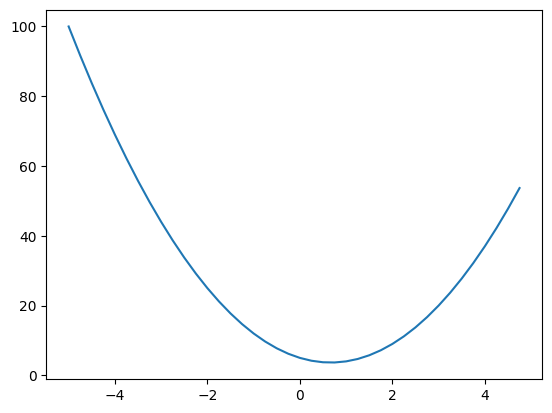

In [6]:
plt.plot(xs,ys)

In [7]:
h = 0.001
x = 3
f(x+h)

20.014003000000002

In [8]:
(f(x+h)-f(x))/h

14.00300000000243

In [9]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print("Original value of d: ", d)

h = 0.001
a += h
d1 = a*b + c
print("Value of d when a changes slightly: ", d1)
print("Derivative of d with respect to a: ", (d1-d)/h)
a -= h

b+= h
d2 = a*b + c
print("Value of d when b changes slightly: ", d2)
print("Derivative of d with respect to b: ", (d2-d)/h)
b -= h

c+=h
d3 = a*b + c
print("Value of d when c changes slightly: ", d3)
print("Derivative of d with respect to c: ", (d3-d)/h)

Original value of d:  4.0
Value of d when a changes slightly:  3.997
Derivative of d with respect to a:  -3.0000000000001137
Value of d when b changes slightly:  4.002
Derivative of d with respect to b:  1.9999999999997797
Value of d when c changes slightly:  4.0009999999999994
Derivative of d with respect to c:  0.9999999999994458


In [10]:
class Value:
    def __init__(self,data, _children = (), _op='', label =''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other ** -1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [11]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [12]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir':'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [13]:
# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias
b = Value(6.8813735870195432, label = 'b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

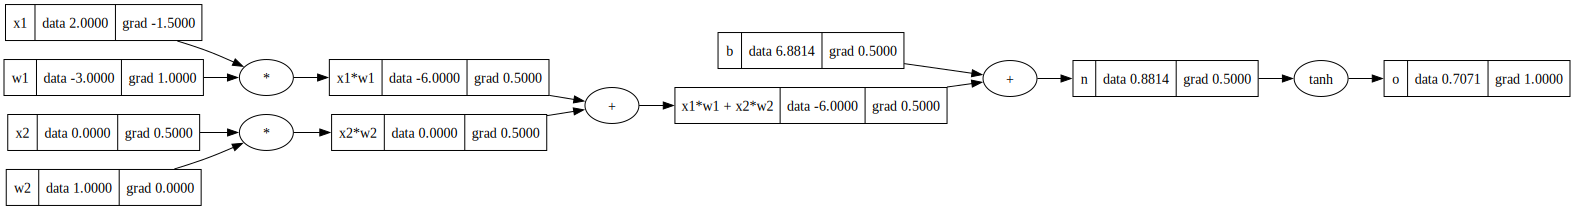

In [14]:
draw_dot(o)

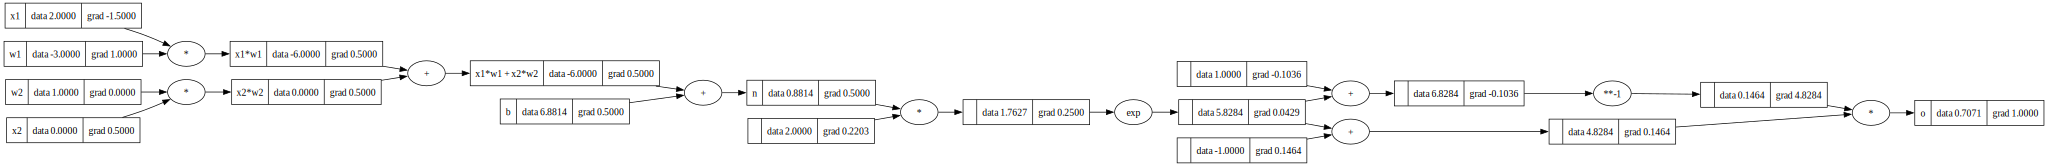

In [15]:
# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias
b = Value(6.8813735870195432, label = 'b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ---
o.label = 'o'
o.backward()
draw_dot(o)

In [16]:
o.backward()

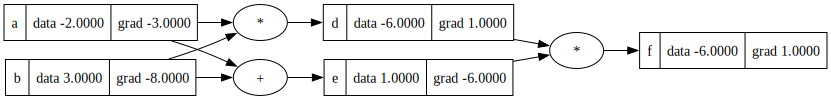

In [17]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'
f.backward()
draw_dot(f)

In [18]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [19]:
x2.grad.item()

0.5000001283844369

In [20]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
        
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
        
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()] # Returns parameters of the layer

# nout in number of neurons in a single layer while nouts is the lists of layers
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts # nouts = [4,20,100] defines a NN with 3 layers with 4 neurons in the first layer, 20 in the 2nd and 100 in the 3rd
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] iterates over the indices of the nouts list.
        # For each index i, a new Layer is created with sz[i] as the number of inputs (nin) and sz[i+1] as the number of neurons (nout) in that layer
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) # The output of previous layer is the input of the next layer
        return x
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1]) # 3 is nin and the list is nouts
n(x)

Value(data=0.009492451265974953)

In [21]:
n.parameters()

[Value(data=0.20159366874123674),
 Value(data=-0.031931536219038215),
 Value(data=-0.13312925625966887),
 Value(data=-0.3994549265158054),
 Value(data=0.7333244152721923),
 Value(data=-0.8304315751263598),
 Value(data=0.4503076314163732),
 Value(data=0.660566533570653),
 Value(data=-0.916790466682817),
 Value(data=0.10215611653067103),
 Value(data=0.18137193998366108),
 Value(data=-0.4568463313199749),
 Value(data=0.562793871719786),
 Value(data=-0.4513920412518697),
 Value(data=0.8954925845358548),
 Value(data=-0.2571446154712742),
 Value(data=-0.7416685488796759),
 Value(data=-0.8780552684154288),
 Value(data=-0.7943401170887558),
 Value(data=0.24488583818006004),
 Value(data=-0.598362684940309),
 Value(data=-0.6009581033338864),
 Value(data=0.08608957229532233),
 Value(data=-0.14183865768075843),
 Value(data=0.5842636421114618),
 Value(data=-0.4483069798958379),
 Value(data=0.7843998905871945),
 Value(data=-0.9315207739365299),
 Value(data=-0.9112550187083077),
 Value(data=0.9534958

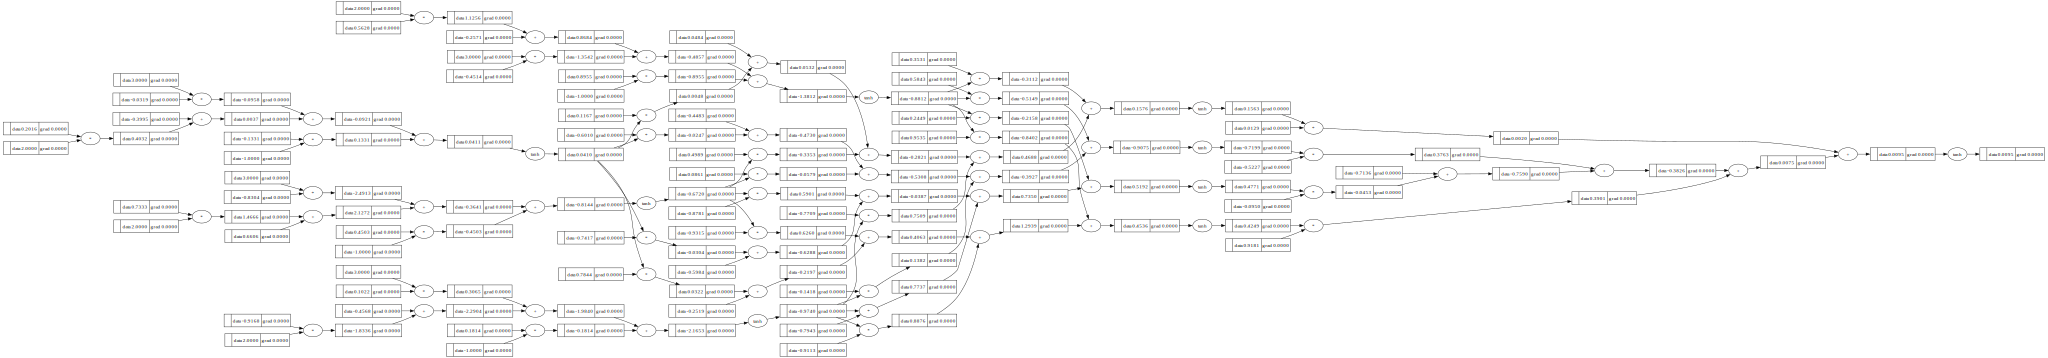

In [22]:
draw_dot(n(x))

In [23]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
] # Output of this NN is yout
ys = [1.0, -1.0, -1.0, 1.0] # desired tagrets (ygt)
ypred = [n(x) for x in xs]
ypred

[Value(data=0.009492451265974953),
 Value(data=-0.1728358590719587),
 Value(data=-0.7452660184919037),
 Value(data=-0.6006813077747278)]

In [24]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.2923757705306915)

In [25]:
loss.backward()

In [26]:
n.layers[0].neurons[0].w[0].grad

-1.3653214300940242

In [27]:
n.layers[0].neurons[0].w[0].data # value of weight

0.20159366874123674

In [28]:
# Negative gradient has implies inverse influence on the loss, so slightly increasing this weight of this neuron of this layer will make the loss go down

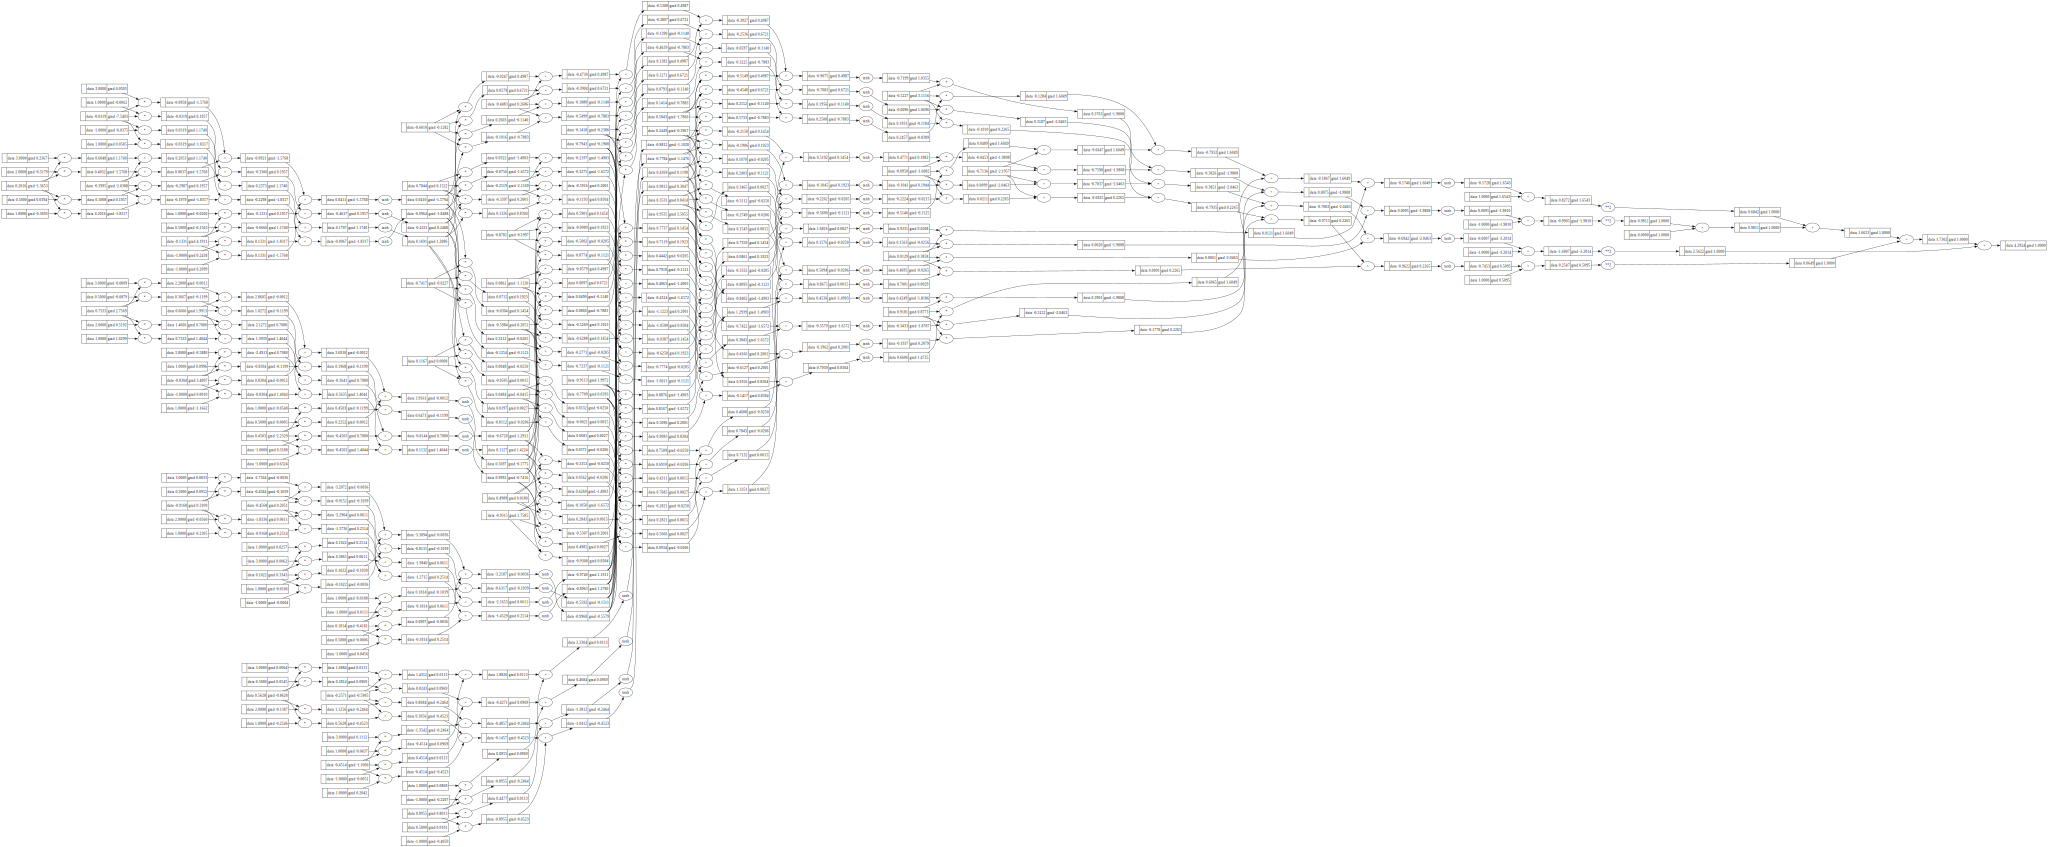

In [29]:
draw_dot(loss)

In [30]:
for p in n.parameters():
    p.data += -0.01 * p.grad # gradient is -ve so multipying with -0.01 will increase the will
# We want to increase the value of the weight as increasing it will make the loss go down, think of gradient as pointing
# in the direction of inreasing loss, here the gradient is -ve so reducing the value will increase the loss, we want to
# reduce the loss

In [31]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # forward pass with adjusted weights 
loss
# re-calculating loss after adjusting parameters according to their gradient

Value(data=2.9314608056477542)

In [32]:
# Loss went down

In [33]:
# Repeating back propogation with adjusted weights and again tuning them

In [34]:
loss.backward() # backward pass with adjusted weights

In [35]:
for p in n.parameters():
    p.data += -0.01 * p.grad # repeat
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=1.4083619868534394)

In [36]:
# Reduced again, this is bascially gradient descent - forward pass with adjusted weights then backward pass with adjusted weights and repeat until loss keeps decreasing

In [37]:
ypred

[Value(data=0.5916626139311043),
 Value(data=-0.3279593739444556),
 Value(data=-0.6097573934725756),
 Value(data=0.20144213047931533)]

In [38]:
# With very low loss the predictions are basically perfect

In [39]:
n.parameters()

[Value(data=0.2266136875089005),
 Value(data=0.1654203908098258),
 Value(data=-0.25311122662282615),
 Value(data=-0.34513808836265814),
 Value(data=0.6561784409657062),
 Value(data=-0.9215637264166621),
 Value(data=0.5179908003886922),
 Value(data=0.601431421771371),
 Value(data=-0.9259353117626739),
 Value(data=0.0929568513259843),
 Value(data=0.19484758844441954),
 Value(data=-0.4629990936636105),
 Value(data=0.5870281309354536),
 Value(data=-0.4217089790644274),
 Value(data=0.8711693531038565),
 Value(data=-0.23958866036111556),
 Value(data=-0.7415515356492958),
 Value(data=-0.8724697189832755),
 Value(data=-0.7891280413706878),
 Value(data=0.2558766698560056),
 Value(data=-0.6039627047623262),
 Value(data=-0.5991536979823214),
 Value(data=0.11839969382309146),
 Value(data=-0.13696638447543524),
 Value(data=0.6355308706936499),
 Value(data=-0.4538021430029001),
 Value(data=0.7842848901760278),
 Value(data=-0.9799563418724014),
 Value(data=-0.9659768571364716),
 Value(data=0.85338926

In [57]:
for k in range(50):
     # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0 # resetting gradients of all weights to zero for every iteration (forgot in prevous run)
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
        
    print(k, loss.data)

0 0.0016247156141345814
1 0.001615658464242681
2 0.0016067007405613906
3 0.0015978408213756152
4 0.0015890771199677288
5 0.0015804080836799798
6 0.0015718321930068297
7 0.001563347960716145
8 0.0015549539309981787
9 0.0015466486786412693
10 0.0015384308082333571
11 0.00153029895338833
12 0.0015222517759963647
13 0.001514287965497297
14 0.0015064062381762913
15 0.0014986053364810263
16 0.0014908840283594923
17 0.0014832411066178623
18 0.0014756753882976844
19 0.0014681857140715275
20 0.0014607709476567824
21 0.0014534299752467033
22 0.0014461617049582232
23 0.001438965066295993
24 0.0014318390096319691
25 0.0014247825057002125
26 0.0014177945451061887
27 0.0014108741378502383
28 0.0014040203128645981
29 0.0013972321175637283
30 0.0013905086174073053
31 0.0013838488954754926
32 0.0013772520520562881
33 0.0013707172042442344
34 0.0013642434855504642
35 0.0013578300455233789
36 0.0013514760493798868
37 0.0013451806776467417
38 0.0013389431258116614
39 0.0013327626039839622
40 0.00132663833

In [58]:
ypred

[Value(data=0.9831462230389492),
 Value(data=-0.9887352429502808),
 Value(data=-0.9834427173073411),
 Value(data=0.9757339348075723)]

In [42]:
# Even closer predictions